In [1]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
import datetime
import yfinance as yf
import lxml
from lxml import html
import requests

In [2]:
#Initialise Parameters

#Choose number of days the algorithm will search for
number_of_days_back = 365

#Choose number of stocks in a portfolio
number_of_stocks = 3

#Empty list for own stock or list with elements for whole market
#names = ['ASX']
names = ['ASX','XRO.AX','APT.AX','PKS.AX', 'BRN.AX', 'A2M.AX']

sector = 'Information Technology'

In [3]:
start_date = datetime.datetime.now() - datetime.timedelta(days=number_of_days_back)
end_date = datetime.datetime.now()

if len(names) == 1:
    #Run this for running whole market
    asx_companies = pd.read_csv('asx_companies.csv')
    asx_companies['names'] = asx_companies['Code'].apply(lambda x: x + '.AX')
    for i in range(len(asx_companies['Sector'])):
        if asx_companies['Sector'][i] == sector:
            names.append(asx_companies['names'][i])

yf.pdr_override()
df = pdr.get_data_yahoo(names, start_date, end_date)
df = df['Adj Close']
df = df.fillna(method='ffill')

normalized_df = (df - df.mean()) / df.std()

benchmark = df['ASX']
normalized_benchmark = normalized_df['ASX']

df = df.drop(columns=['ASX'])
df

[*********************100%***********************]  6 of 6 completed


,A2M.AX,APT.AX,BRN.AX,PKS.AX,XRO.AX
Date,,,,,
2020-01-27,NaN,NaN,NaN,NaN,NaN
2020-01-28,15.08,36.700001,0.051,0.160,83.209999
2020-01-29,15.14,37.990002,0.050,0.155,85.360001
2020-01-30,14.78,37.799999,0.051,0.150,85.449997
2020-01-31,14.51,38.549999,0.051,0.150,85.580002
...,...,...,...,...,...
2021-01-19,10.19,134.000000,0.550,0.390,137.660004
2021-01-20,10.22,141.000000,0.635,0.380,136.270004
2021-01-21,10.10,149.000000,0.605,0.380,136.080002


In [4]:
from itertools import combinations

#Finds the combination of available portfolios given the number of stocks available and number of stocks wanted
sample_size = math.factorial(len(names[1:])) // (math.factorial(len(names[1:]) - number_of_stocks) * math.factorial(number_of_stocks))
print('Number of Portfolios Generated: ' + str(sample_size))

#Creating an array of zeros with sample size x
percent_vols = np.zeros((sample_size, 1))
percent_ret = np.zeros((sample_size, 1))

#Empty Lists
w_list = []
names_list = []

#Choosing all possible combinations of stock choices
combinations = list(combinations(names[1:], number_of_stocks))

for idx in range(len(combinations)):
    port = df[list(combinations[idx])]
    
#Daily simple returns
    returns = port.pct_change()
#Assigning weights to the stock to create a portfolio
    r = np.array(np.mean(returns, axis=0))
#Covariance matrix between stocks (in array)
    S = np.array(returns.cov())
#Vector of 1's equal in length to r
    e = np.ones(len(r))

    def objective(w):
        return np.matmul(np.matmul(w,S),w)

#Set initial weight values
    w = np.random.random(len(r))
#Define Constraints
    const = ({'type' : 'eq' , 'fun' : lambda w: np.dot(w,e) - 1})    # sum(w) - 1 = 0
#Create Bounds
#Creates a tuple of tuples to pass to minimize
#to ensure all weights are betwen [0, inf]
    non_neg = []
    for i in range(len(r)):
        non_neg.append((0,None))
    non_neg = tuple(non_neg)

#Run optimization with SLSQP solver
    solution = minimize(fun=objective, x0=w, method='SLSQP',constraints=const,bounds=non_neg)
    w = solution.x.round(6)
    print(str(idx + 1) + '/' + str(sample_size))
    
#Assign values into the empty list
    w_list.append(w)
    names_list.append(list(returns.columns[w > 0.0]))

#Find co-variance to see how much each stock varies
    cov_matrix_annual = returns.cov() * 252 
#Expected portfolio variance= WT * (Covariance Matrix) * W
    port_variance = np.dot(w.T, np.dot(cov_matrix_annual, w))
#Expected portfolio volatility= SQRT (WT * (Covariance Matrix) * W)
    port_volatility = np.sqrt(port_variance)
#Portfolio annual simple return
    portfolioSimpleAnnualReturn = np.sum(returns.mean() * w) * 252
    
#Annual return and volatility.
    percent_vols[idx] = port_volatility * 100
    percent_ret[idx] = portfolioSimpleAnnualReturn * 100
    
#appending array into a dataframe
generated_portfolios = pd.DataFrame(columns = ['return', 'volatility'])
generated_portfolios['return'] = percent_ret[:,0]
generated_portfolios['volatility'] = percent_vols[:,0]

Number of Portfolios Generated: 10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [5]:
#Finding the Portfolio with the maximum gradient
generated_portfolios['gradient'] = generated_portfolios['return'] / generated_portfolios['volatility']
generated_portfolios['names'] = names_list
generated_portfolios['weights'] = w_list

generated_portfolios = generated_portfolios.sort_values(by='gradient', ascending=False)
Optimal_portfolio = generated_portfolios.head(50)
Optimal_portfolio_ids = Optimal_portfolio.index

In [6]:
for i in Optimal_portfolio_ids:
    print('Name: ' + str(Optimal_portfolio['names'][i]))
    print('Weights: ' + str(Optimal_portfolio['weights'][i]))
    print('Return: ' + str(round(Optimal_portfolio['return'][i], 2)) + '%')
    print('Volatility: ' + str(round(Optimal_portfolio['volatility'][i], 2)) + '%')
    print('Gradient: ' + str(round(Optimal_portfolio['gradient'][i], 2)) + '%')
    print('')

Name: ['APT.AX', 'PKS.AX', 'BRN.AX']
Weights: [0.262147 0.595836 0.142016]
Return: 162.78%
Volatility: 60.08%
Gradient: 2.71%

Name: ['XRO.AX', 'PKS.AX']
Weights: [0.652496 0.       0.347504]
Return: 77.68%
Volatility: 39.37%
Gradient: 1.97%

Name: ['XRO.AX', 'PKS.AX']
Weights: [0.65267 0.34733 0.     ]
Return: 77.68%
Volatility: 39.37%
Gradient: 1.97%

Name: ['XRO.AX', 'BRN.AX']
Weights: [0.932003 0.       0.067997]
Return: 76.96%
Volatility: 42.78%
Gradient: 1.8%

Name: ['XRO.AX', 'BRN.AX', 'A2M.AX']
Weights: [0.610587 0.029724 0.359689]
Return: 35.36%
Volatility: 36.0%
Gradient: 0.98%

Name: ['XRO.AX', 'PKS.AX', 'A2M.AX']
Weights: [0.215147 0.192224 0.592629]
Return: 17.42%
Volatility: 32.99%
Gradient: 0.53%

Name: ['PKS.AX', 'BRN.AX', 'A2M.AX']
Weights: [0.263671 0.025273 0.711057]
Return: 17.52%
Volatility: 36.25%
Gradient: 0.48%

Name: ['PKS.AX', 'A2M.AX']
Weights: [0.       0.230837 0.769163]
Return: 4.02%
Volatility: 36.59%
Gradient: 0.11%

Name: ['APT.AX', 'BRN.AX', 'A2M.AX']


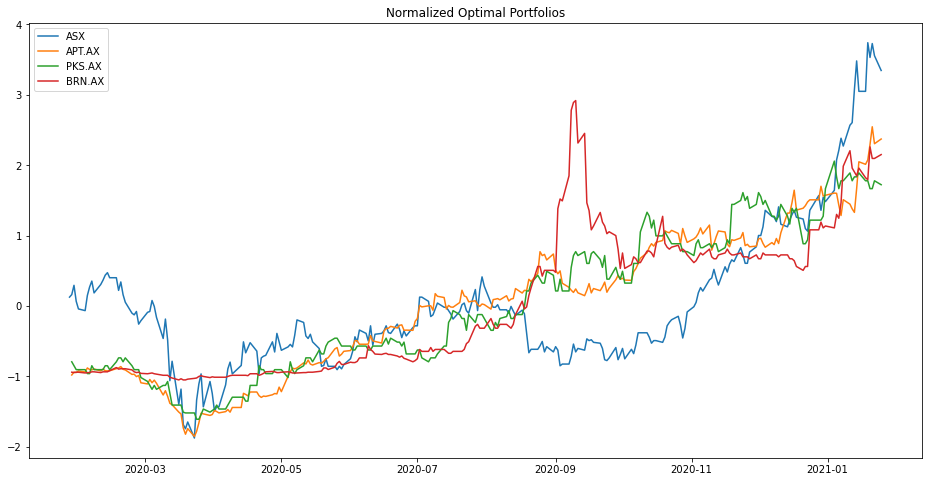

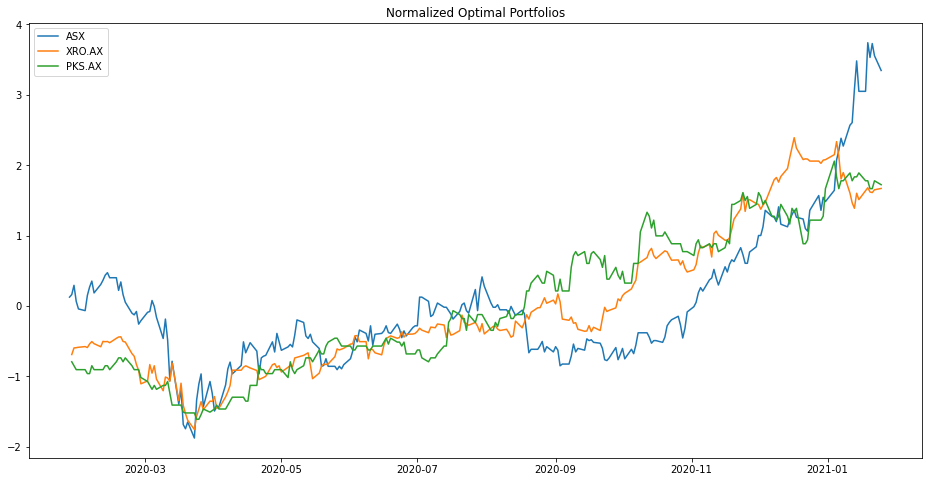

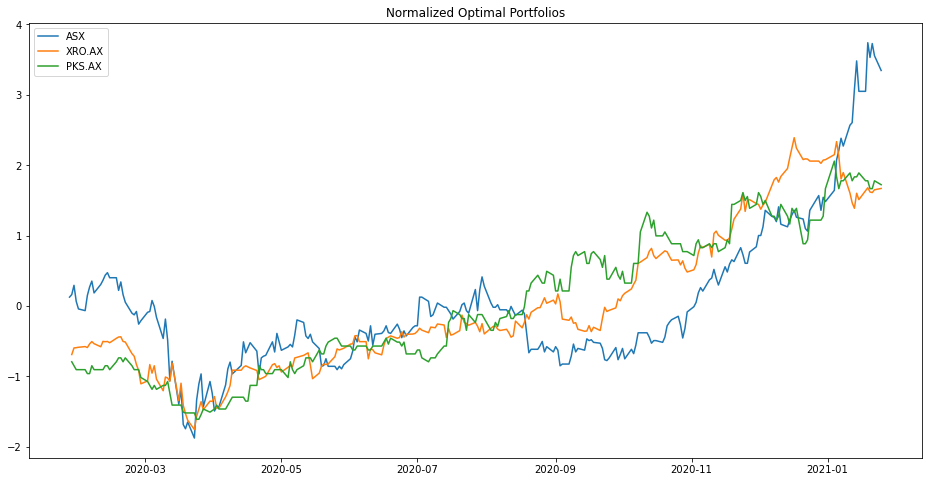

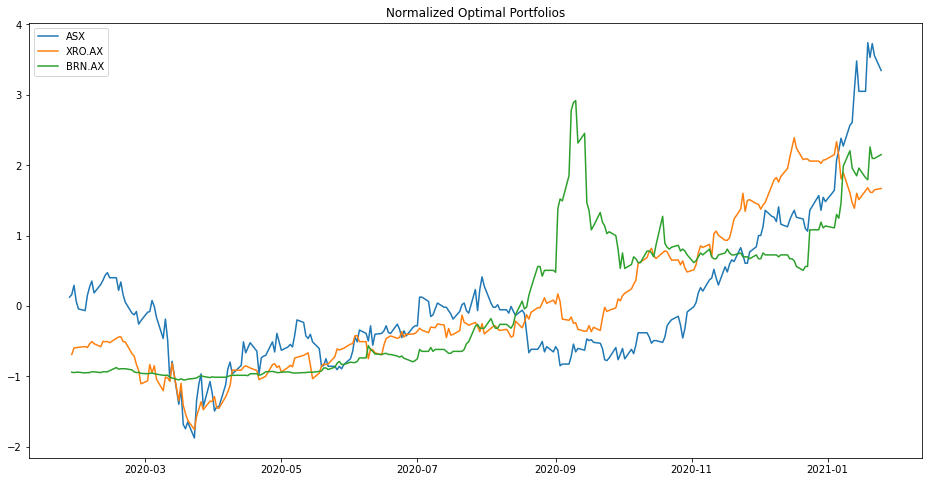

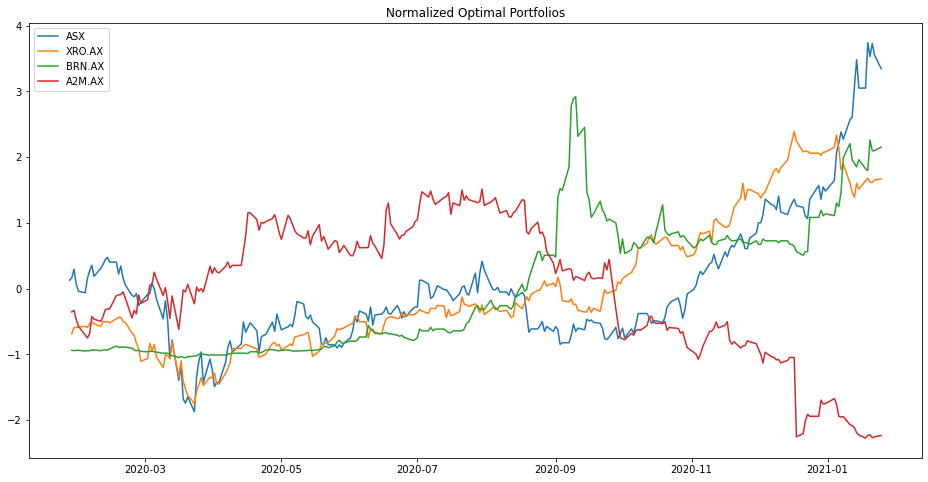

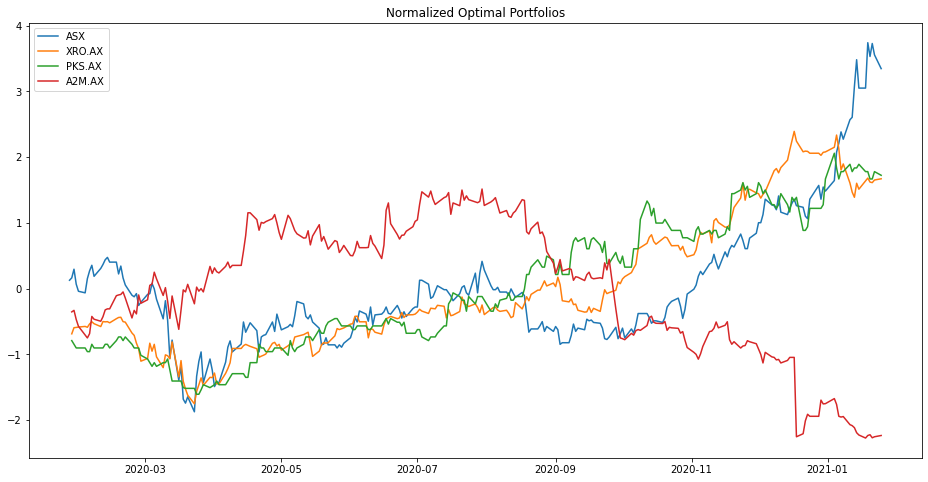

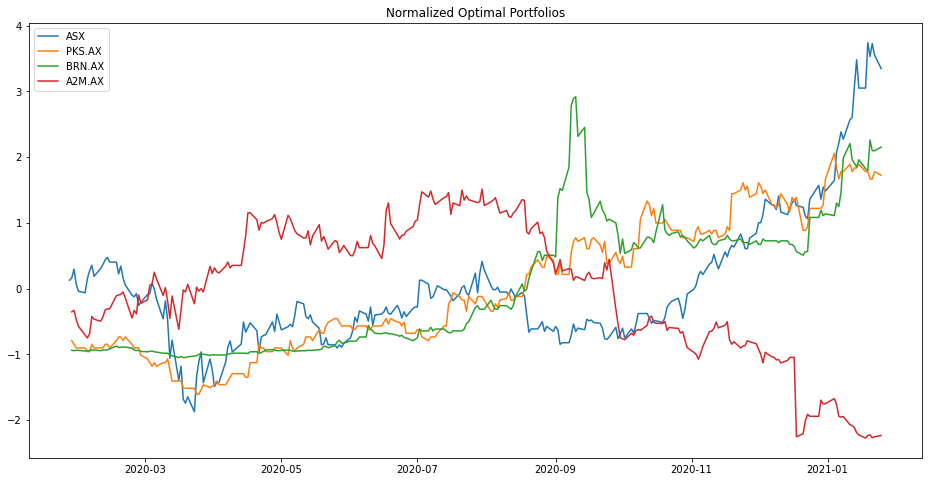

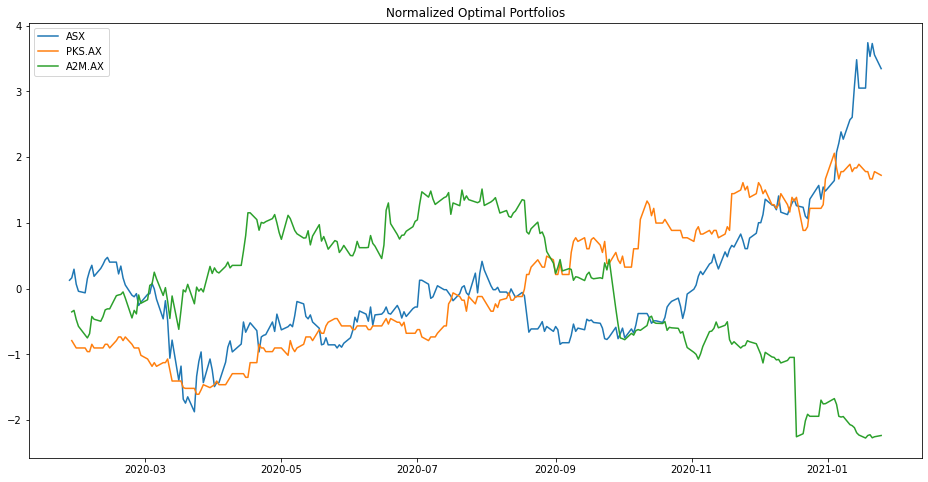

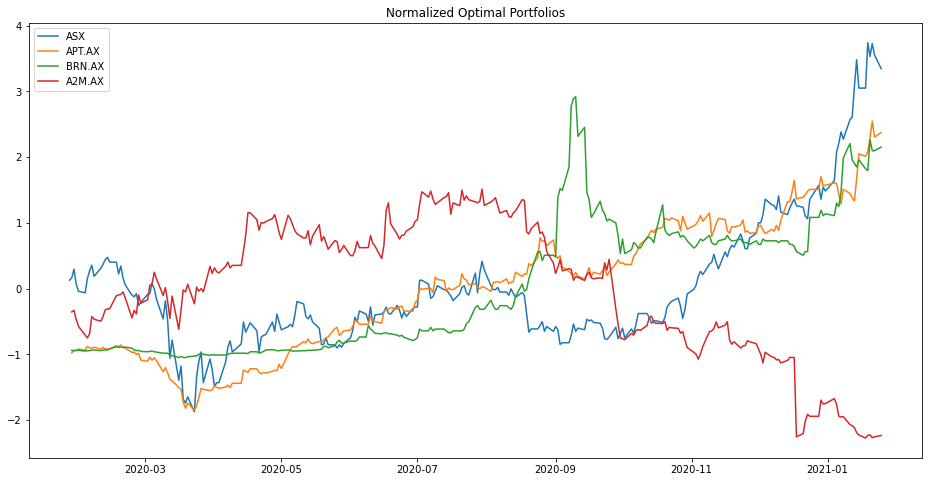

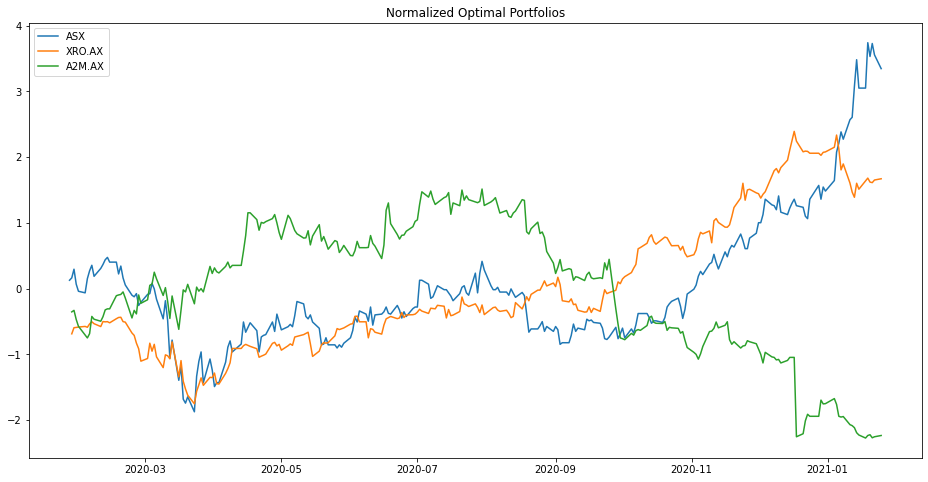

In [7]:
index = 0
for i in Optimal_portfolio_ids:
    index += 1
    fig, ax = plt.subplots(figsize=(16,8))
    plt.title('Normalized Optimal Portfolios')
    ax.plot(normalized_df.index, normalized_benchmark, label = 'ASX')
    for j in range(len(Optimal_portfolio['names'][i])):
        ax.plot(normalized_df.index, normalized_df[Optimal_portfolio['names'][i][j]], label = Optimal_portfolio['names'][i][j])
    ax.legend()
    plt.savefig(r'optimal_portfolio_graphs/normalized_optimal_portfolios' + str(index) + '.png')

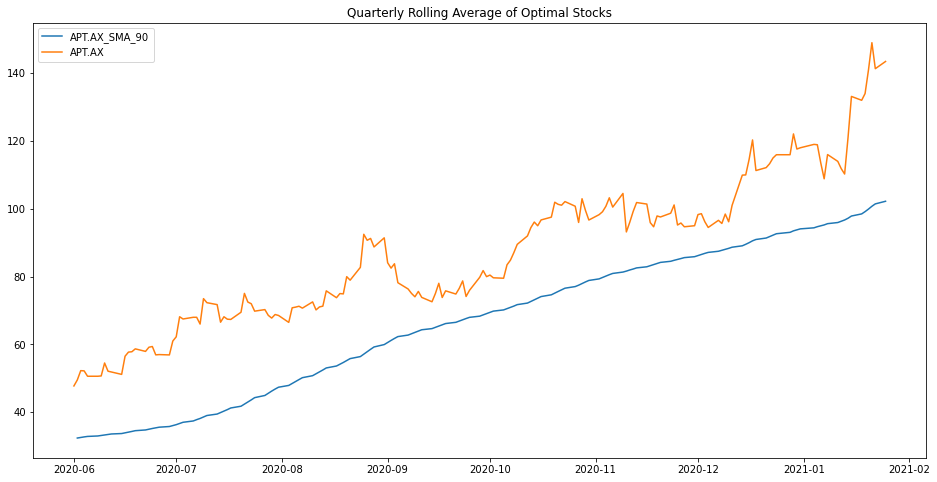

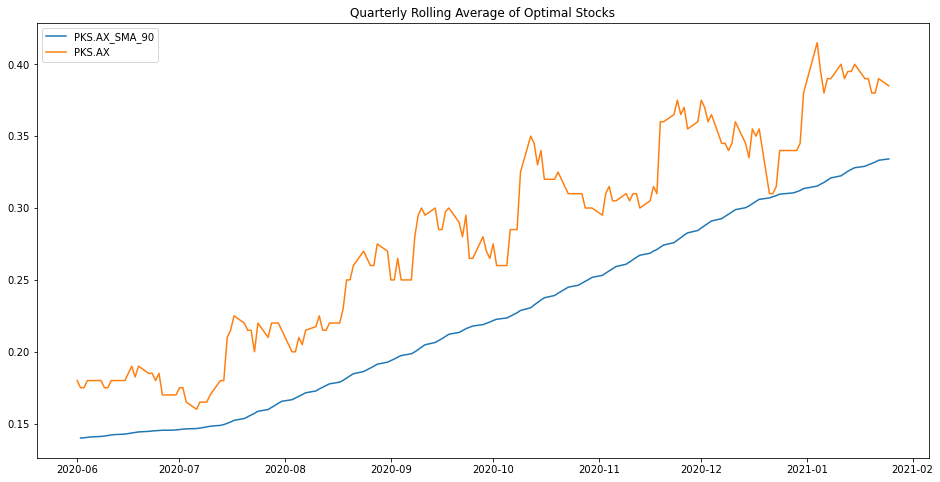

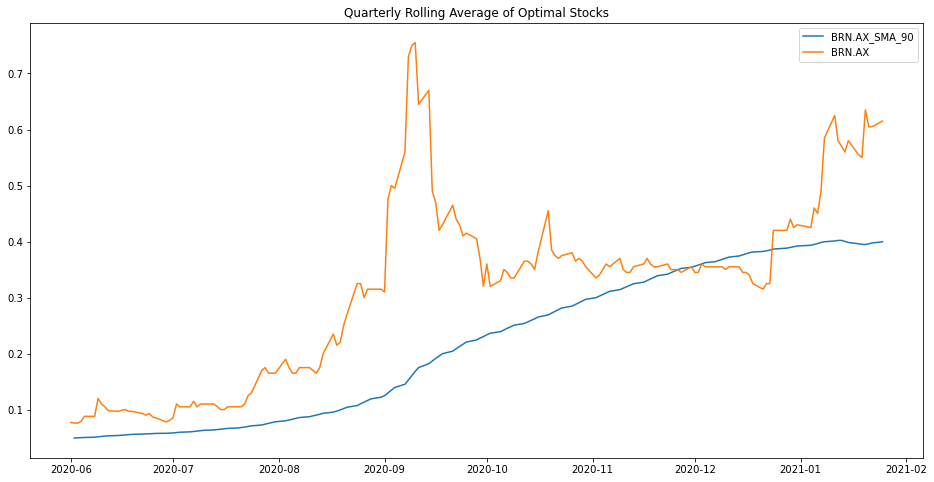

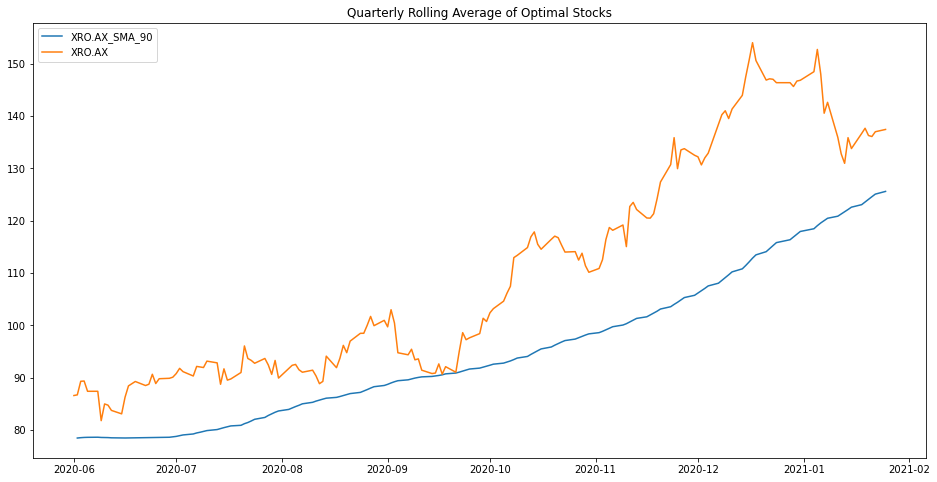

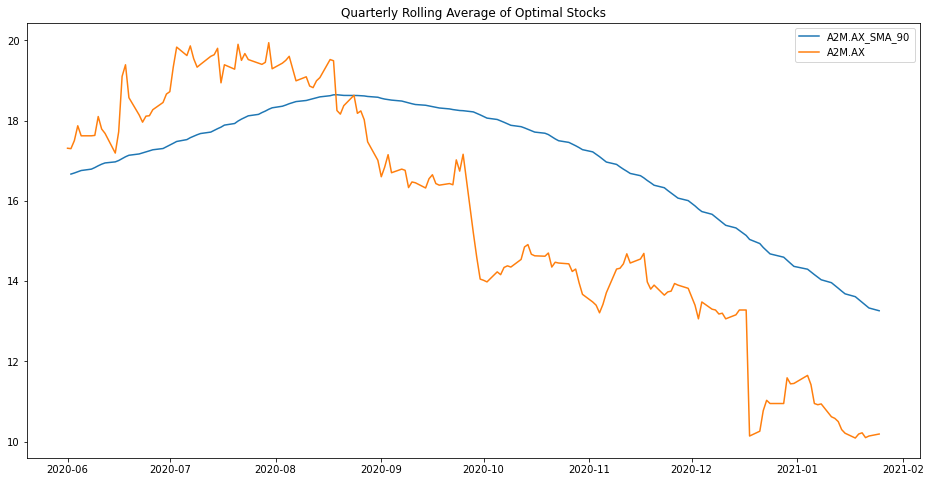

In [8]:
index = 0
if number_of_days_back <= 30:
    
    df_SMA = pd.DataFrame()
    for i in Optimal_portfolio_ids:
        for j in range(len(Optimal_portfolio['names'][i])):
            name = Optimal_portfolio['names'][i][j]
            df_SMA[name] = df[name].rolling(window=7).mean()

    for i in range(len(df_SMA.columns)):
        index += 1
        fig, ax = plt.subplots(figsize=(16,8))
        plt.title('Weekly Rolling Average of Optimal Stocks')
        ax.plot(df_SMA[6:].index, df_SMA[6:][df_SMA.columns[i]], label = df_SMA.columns[i] + '_SMA_7')
        ax.plot(df[6:].index, df[6:][df_SMA.columns[i]], label = df_SMA.columns[i])
        ax.legend()
        plt.savefig(r'rolling_average_graphs/rolling_average_of_optimal_stocks' + str(index) + '.png')
        
if number_of_days_back > 30 and number_of_days_back < 365:
    
    df_SMA = pd.DataFrame()
    for i in Optimal_portfolio_ids:
        for j in range(len(Optimal_portfolio['names'][i])):
            name = Optimal_portfolio['names'][i][j]
            df_SMA[name] = df[name].rolling(window=30).mean()
            
    for i in range(len(df_SMA.columns)):
        index += 1
        fig, ax = plt.subplots(figsize=(16,8))
        plt.title('Monthly Rolling Average of Optimal Stocks')
        ax.plot(df_SMA[29:].index, df_SMA[29:][df_SMA.columns[i]], label = df_SMA.columns[i] + '_SMA_30')
        ax.plot(df[29:].index, df[29:][df_SMA.columns[i]], label = df_SMA.columns[i])
        ax.legend()
        plt.savefig(r'rolling_average_graphs/rolling_average_of_optimal_stocks' + str(index) + '.png')
        
if number_of_days_back >= 365:
    
    df_SMA = pd.DataFrame()
    for i in Optimal_portfolio_ids:
        for j in range(len(Optimal_portfolio['names'][i])):
            name = Optimal_portfolio['names'][i][j]
            df_SMA[name] = df[name].rolling(window=90).mean()

    for i in range(len(df_SMA.columns)):
        index += 1
        fig, ax = plt.subplots(figsize=(16,8))
        plt.title('Quarterly Rolling Average of Optimal Stocks')
        ax.plot(df_SMA[89:].index, df_SMA[89:][df_SMA.columns[i]], label = df_SMA.columns[i] + '_SMA_90')
        ax.plot(df[89:].index, df[89:][df_SMA.columns[i]], label = df_SMA.columns[i])
        ax.legend()
        plt.savefig(r'rolling_average_graphs/rolling_average_of_optimal_stocks' + str(index) + '.png')
        set(df_SMA[89:][df_SMA.columns[i]]) & set(df[89:][df_SMA.columns[i]])

In [9]:
print('Over/Under Valued')
for i in range(len(df_SMA.columns)):
    print(df_SMA.columns[i] + ': ' + str(round(((df[df_SMA.columns[i]][-1] - df_SMA[df_SMA.columns[i]][-1]) / df_SMA[df_SMA.columns[i]][-1]), 2)) + '%')

Over/Under Valued
APT.AX: 0.4%
PKS.AX: 0.15%
BRN.AX: 0.54%
XRO.AX: 0.09%
A2M.AX: -0.23%


In [20]:
for i in range(len(df_SMA.columns)):
    ticker = yf.Ticker(df_SMA.columns[i])
    json_data = ticker.info
    
    try:
        json_longName = json_data['longName']
    except:
        json_LongName = 'None'
    print(json_longName)
    
    try:
        json_country = json_data['country']
    except:
        json_country = ''
    try:
        json_city = json_data['city']
    except:
        json_city = ''
    try:
        json_address1 = json_data['address1']
    except:
        json_address1 = ''
    try:
        json_address2 = json_data['address2']
    except:
        json_address2 = ''
    print('Address: ' + json_address2 + ', ' + json_address1 + ', ' + json_city + ', ' + json_country)
    
    try:
        json_sector = json_data['sector']
    except:
        json_sector = 'None'
    try:
        json_industry = json_data['industry']
    except:
        json_industry: 'None'
    print('Industry and Sector: ' + json_industry + ', ' + json_sector)
    
    try:
        json_longBusinessSummary = json_data['longBusinessSummary']
    except:
        json_longBusinessSummary = 'None'
    print(json_longBusinessSummary)
    
    try:
        json_fullTimeEmployees = json_data['fullTimeEmployees']
    except: 
        json_fullTimeEmployees = 'None'
    print('Full Time Employees: ' + str(json_fullTimeEmployees))
    
    try:
        json_marketCap = json_data['marketCap']
    except:
        json_marketCap = 'None'
    print('Market Cap: ' + '$' + str(json_marketCap))
    
    for j in range(len(ticker.major_holders[0])):
        print(ticker.major_holders[0][j] + ' ' + ticker.major_holders[1][j].replace('% ', ''))
    
    print()

Afterpay Limited
Address: Level 5, 406 Collins Street, Melbourne, Australia
Industry and Sector: Software—Infrastructure, Technology
Afterpay Limited provides payments solutions for customers, merchants, and businesses in Australia, New Zealand, the United States, Canada, and the United Kingdom. The company operates through Afterpay ANZ, Afterpay US, Clearpay, and Pay Now segments. The company offers Afterpay and Clearpay services; and Pay Now services comprising mobility, health, and e-services. The company was formerly known as Afterpay Touch Group Limited and changed its name to Afterpay Limited in November 2019. Afterpay Limited was incorporated in 2017 and is based in Melbourne, Australia.
Full Time Employees: 665
Market Cap: $41083645952
36.71% of Shares Held by All Insider
27.42% of Shares Held by Institutions
43.31% of Float Held by Institutions
190 Number of Institutions Holding Shares

PKS Holdings Limited
Address: 3rd floor Suite 310, 50 Holt Street, Surry Hills, Australia
I

In [22]:
def get_page(url):
    # Set up the request headers that we're going to use, to simulate
    # a request by the Chrome browser. Simulating a request from a browser
    # is generally good practice when building a scraper
    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Pragma': 'no-cache',
        'Referrer': 'https://google.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'
    }

    return requests.get(url, headers=headers)

def parse_rows(table_rows):
    parsed_rows = []

    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")

        none_count = 0

        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append(np.NaN)
                none_count += 1

        if (none_count < 4):
            parsed_rows.append(parsed_row)
            
    return pd.DataFrame(parsed_rows)

def clean_data(df):
    df = df.set_index(0) # Set the index to the first column: 'Period Ending'.
    df = df.transpose() # Transpose the DataFrame, so that our header contains the account names
    
    # Rename the "Breakdown" column to "Date"
    cols = list(df.columns)
    cols[0] = 'Date'
    df = df.set_axis(cols, axis='columns', inplace=False)
    
    numeric_columns = list(df.columns)[1::] # Take all columns, except the first (which is the 'Date' column)

    for column_index in range(1, len(df.columns)): # Take all columns, except the first (which is the 'Date' column)
        df.iloc[:,column_index] = df.iloc[:,column_index].str.replace(',', '') # Remove the thousands separator
        df.iloc[:,column_index] = df.iloc[:,column_index].astype(np.float64) # Convert the column to float64
        
    return df

def scrape_table(url):
    # Fetch the page that we're going to parse
    page = get_page(url);

    # Parse the page with LXML, so that we can start doing some XPATH queries
    # to extract the data that we want
    tree = html.fromstring(page.content)

    # Fetch all div elements which have class 'D(tbr)'
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]")
    
    # Ensure that some table rows are found; if none are found, then it's possible
    # that Yahoo Finance has changed their page layout, or have detected
    # that you're scraping the page.
    assert len(table_rows) > 0
    
    df = parse_rows(table_rows)
    df = clean_data(df)
        
    return df

In [21]:
symbol = 'BRN.AX'
df_balance_sheet = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol)
df_income_statement = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/financials?p=' + symbol)
df_cash_flow = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/cash-flow?p=' + symbol)